# Introduction
## 24-Hour Forecasting of Solana Cryptocurrency Prices Using LSTM Time Series Models

In [46]:

## Objective
"""This project aims to forecast 24-hours Solana cryptocurrency prices using various time series models
   to assist stakeholders in making informed investment decisions."""

## Scope
"""We will evaluate different models, including LSTM and Prophet, to identify the best performing model for accurate predictions."""

## Tools and Technologies
#- Python
#- TensorFlow
#- Prophet
#- Pandas
#- Numpy
#- Matplotlib


'We will evaluate different models, including LSTM and Prophet, to identify the best performing model for accurate predictions.'

# Data Collection and Preparation
### Import Necessary Libraries

In [47]:
import pandas as pd
import numpy as np
import ta  # Technical Analysis library for financial indicators
from sklearn.preprocessing import MinMaxScaler
import joblib  # For saving models or transformations
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D
from sklearn.model_selection import GridSearchCV

## Define Functions for Each Step of the Pipeline
### Data Loading and Cleaning

In [48]:
def load_and_clean_data(file_path):
    # Load CSV file
    # file_path = "https://raw.githubusercontent.com/ajkamali/Solana-/main/df_solana.csv"
    df_solana = pd.read_csv(file_path)

    # Drop unnecessary columns
    df_solana_dropped = df_solana.drop(['timestamp_y'], axis=1)

    # Reindex to move timestamp_H to the first position
    df_new = df_solana_dropped.reindex(columns=['timestamp_H', *df_solana_dropped.columns.difference(['timestamp_H'])])

    # Sort the DataFrame by timestamp_H in ascending order and drop the first row (null value)
    df_sorted = df_new.sort_values(by='timestamp_H', ascending=True).reset_index(drop=True).iloc[1:]

    # Convert to datetime columns
    df_sorted['timestamp_H'] = pd.to_datetime(df_sorted['timestamp_H'])
    df_sorted['timestamp_x'] = pd.to_datetime(df_sorted['timestamp_x'])

    # Creating timestamp_HH as index for the dataframe
    df_sorted['timestamp_HH'] = df_sorted['timestamp_H']
    df_sorted.set_index('timestamp_HH', inplace=True)

    return df_sorted


### Handle Missing Timestamps

In [49]:
def fill_missing_timestamps(df):
    # Create a full datetime index from start to end with hourly frequency
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

    # Compare the full index with dataframe's index to find missing times
    missing_times = full_index.difference(df.index)

    new_rows = []

    for missing_ts in missing_times:
        before = df.loc[missing_ts - pd.Timedelta(hours=1)]
        after = df.loc[missing_ts + pd.Timedelta(hours=1)]

        new_row = {}
        for col in df.columns:
            if col == 'timestamp_H':  # Assigning Period directly
                new_row[col] = pd.Period(missing_ts, freq='H')
            elif col == 'timestamp_x':  # Handling timestamp_x as datetime
                new_row[col] = missing_ts
            else:
                if pd.notna(before[col]) and pd.notna(after[col]):
                    new_row[col] = np.mean([before[col], after[col]])
                else:
                    new_row[col] = before[col] if pd.notna(before[col]) else after[col]

        new_rows.append(pd.Series(new_row, name=missing_ts))

    df = pd.concat([df, pd.DataFrame(new_rows)], axis=0).sort_index()

    return df[~df.index.duplicated(keep='first')] # Handling duplicates and returning df


### Feature Engineering

In [50]:
def add_features(df, dropna=True):
    # Rolling averages and lag features to capture daily trends
    """
      Adds rolling average and lag features for each applicable column in the DataFrame.

      Drops rows with NaN values.


      Parameters:

      df: The input DataFrame.

      dropna (bool): Flag to drop rows with NaN values after feature creation.


      Returns:

      df: The DataFrame with additional features.

      """


    df_new = df.copy()
    
    numeric_cols = df_new.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df_new[f'rolling_avg_24hr_{col}'] = df_new[col].rolling(window=24, min_periods=1).mean()
        df_new[f'lag_24hr_{col}'] = df_new[col].shift(24)
    
    if dropna:
        df_new.dropna(inplace=True)
   
    return df_new

def engineer_features(df):
    df = add_features(df, dropna=True)

    # Add more features related to time
    df['hour'] = df['timestamp_x'].dt.hour
    df['day_of_week'] = df['timestamp_x'].dt.dayofweek
    df['day_of_month'] = df['timestamp_x'].dt.day
    df['month'] = df['timestamp_x'].dt.month
    df['year'] = df['timestamp_x'].dt.year

    # Adding technical indicators
    df['sma'] = ta.trend.sma_indicator(df['price_solana'], window=14)
    df['rsi'] = ta.momentum.rsi(df['price_solana'], window=14)
    df['macd'] = ta.trend.macd(df['price_solana'])

    df.fillna(0, inplace=True)
    return df

### Data Normalization

In [51]:
def normalize_data(df):
    features = df[['rolling_avg_24hr_market_cap_bitcoin', 'lag_24hr_market_cap_bitcoin',
           'rolling_avg_24hr_market_cap_solana', 'lag_24hr_market_cap_solana',
           'rolling_avg_24hr_price_bitcoin', 'lag_24hr_price_bitcoin',
           'rolling_avg_24hr_price_solana', 'lag_24hr_price_solana',
           'rolling_avg_24hr_total_volume_bitcoin',
           'lag_24hr_total_volume_bitcoin', 'rolling_avg_24hr_total_volume_solana',
           'lag_24hr_total_volume_solana', 'hour', 'day_of_week', 'day_of_month',
           'month', 'year', 'sma', 'rsi', 'macd']]

    price_solana = df[['price_solana']]

    # Initialize and fit the scaler
    scaler = MinMaxScaler()
    features_scaled = scaler.fit_transform(features)

    # Normalize 'price_solana'
    scaler_price = MinMaxScaler()
    price_solana_scaled = scaler_price.fit_transform(price_solana)

    # Create a DataFrame with scaled features
    features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)
    price_solana_scaled_df = pd.DataFrame(price_solana_scaled, columns=price_solana.columns)

    # Attach timestamps back to the scaled DataFrame
    features_scaled_df['timestamp_H'] = df['timestamp_H'].values

    return features_scaled_df, price_solana_scaled_df, scaler_price


### Sequence Data Preparation

In [52]:
def create_sequences(features, target, sequence_length=24):
    X = []
    y = []
    for i in range(len(features) - sequence_length):
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    return np.array(X), np.array(y)

def prepare_sequences(features_scaled_df, price_solana_scaled_df):
    X, y = create_sequences(features_scaled_df[['rolling_avg_24hr_market_cap_bitcoin', 'lag_24hr_market_cap_bitcoin',
           'rolling_avg_24hr_market_cap_solana', 'lag_24hr_market_cap_solana',
           'rolling_avg_24hr_price_bitcoin', 'lag_24hr_price_bitcoin',
           'rolling_avg_24hr_price_solana', 'lag_24hr_price_solana',
           'rolling_avg_24hr_total_volume_bitcoin',
           'lag_24hr_total_volume_bitcoin', 'rolling_avg_24hr_total_volume_solana',
           'lag_24hr_total_volume_solana', 'hour', 'day_of_week', 'day_of_month',
           'month', 'year', 'sma', 'rsi', 'macd']].values, price_solana_scaled_df['price_solana'].values)
    
    #Spliting the data 
    # Define a cutoff point for the train-test split
    test_size = 240 # Number of rows for the test set (last 240 hrs)
    X_train, X_test =  X[:-test_size], X[-test_size:] # Training data excludes the last test_size rows and Test data includes the last test_size rows
    y_train, y_test = y[:-test_size], y[-test_size:]

    return X_train, X_test, y_train, y_test


# Define Different Model Functions

## Define and Train Simple LSTM Model

In [53]:
def simple_lstm_model(X_train, y_train):
    model = Sequential([
        LSTM(100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
        LSTM(100, activation='relu', return_sequences=True),
        LSTM(100, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=5, batch_size=24, verbose=0, validation_split=0.1)

    return model, history


## Model 2: Adding Convolutional Layers to the LSTM Model

In [54]:
def model_with_conv1d(X_train, y_train):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(100, activation='relu', return_sequences=True),
        LSTM(100, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, y_train, epochs=5, batch_size=24, verbose=0, validation_split=0.1)
    
    return model, history


## Model 3: Using a Custom Loss Function for Convolutional Layers

In [55]:
def model_with_custom_loss(X_train, y_train):
    def custom_loss(y_true, y_pred):
        return K.mean(K.square(y_pred - y_true), axis=-1) + K.mean(K.abs(y_pred - y_true), axis=-1)  # MSE + MAE

    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        MaxPooling1D(pool_size=2),
        LSTM(100, activation='relu', return_sequences=True),
        LSTM(100, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss=custom_loss)
    history = model.fit(X_train, y_train, epochs=5, batch_size=24, verbose=0, validation_split=0.1)
    
    return model, history


### Function for Evaluating LSTM Models

In [56]:

def evaluate_model(model, X_test, y_test, scaler_price, history, model_name):
    test_loss = model.evaluate(X_test, y_test)

    y_pred = model.predict(X_test)

    y_test_scaled = y_test.reshape(-1, 1)
    y_pred_scaled = y_pred.reshape(-1, 1)

    y_test = scaler_price.inverse_transform(y_test_scaled)
    y_pred = scaler_price.inverse_transform(y_pred_scaled)

    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

    plt.figure(figsize=(6, 3))
    plt.plot(y_test, label='Actual Solana Price')
    plt.plot(y_pred, label='Predicted Solana Price', alpha=0.7)
    plt.title(f'Actual vs Predicted Solana Prices - {model_name}')
    plt.xlabel('Time (hours)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return metrics



## Add Function for Training and Evaluating the Prophet Model

In [57]:
from prophet import Prophet

def train_and_evaluate_prophet(df):
    df.rename(columns={'timestamp_x': 'ds', 'price_solana': 'y'}, inplace=True)

    # List of additional features to be used as regressors
    additional_features = [
        'rolling_avg_24hr_market_cap_bitcoin', 'lag_24hr_market_cap_bitcoin',
        'rolling_avg_24hr_market_cap_solana', 'lag_24hr_market_cap_solana',
        'rolling_avg_24hr_price_bitcoin', 'lag_24hr_price_bitcoin',
        'rolling_avg_24hr_price_solana', 'lag_24hr_price_solana',
        'rolling_avg_24hr_total_volume_bitcoin', 'lag_24hr_total_volume_bitcoin',
        'rolling_avg_24hr_total_volume_solana', 'lag_24hr_total_volume_solana',
        'hour', 'day_of_week', 'day_of_month', 'month', 'year',
        'sma', 'rsi', 'macd'
    ]

    df[additional_features] = df[additional_features].ffill().bfill().fillna(0)

    # Split data into training and test sets
    test_size = 240                 # Number of rows for the test set (last 240 hrs)
    df_train = df.iloc[:-test_size]
    df_test = df.iloc[-test_size:]

    # Initialize the Prophet model
    model = Prophet()

    # Add each additional feature as a regressor
    for feature in additional_features:
        model.add_regressor(feature)

    # Fit the model
    model.fit(df_train[['ds', 'y'] + additional_features])

    # Create a dataframe for future predictions
    future = df_test[['ds'] + additional_features]

    # Predict
    forecast = model.predict(future)

    # Compare predictions with actual values
    y_true = df_test['y'].values
    y_pred = forecast['yhat'].values

    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae
    }

    plt.figure(figsize=(6, 3))
    plt.plot(y_true, label='Actual Solana Price')
    plt.plot(y_pred, label='Predicted Solana Price', alpha=0.7)
    plt.title('Actual vs Predicted Solana Prices (Prophet)')
    plt.xlabel('Time (hours)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return forecast, metrics


#  Define the Pipeline Function

In [58]:

def run_pipeline(file_path, model_fn=None,model_name=None, use_prophet=False):
    # Suppress All Warnings
    import warnings
    warnings.filterwarnings('ignore')

    df_sorted = load_and_clean_data(file_path)
    df_filled = fill_missing_timestamps(df_sorted)
    df_engineered = engineer_features(df_filled)
    features_scaled_df, price_solana_scaled_df, scaler_price = normalize_data(df_engineered)

    if use_prophet:
        prophet_predictions, prophet_metrics = train_and_evaluate_prophet(df_engineered)
        return prophet_metrics

    X_train, X_test, y_train, y_test = prepare_sequences(features_scaled_df, price_solana_scaled_df)
    model, history = model_fn(X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test, scaler_price, history,model_name)
    return metrics



## Run the Pipeline for Each Model and Compare Metrics

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.9105e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


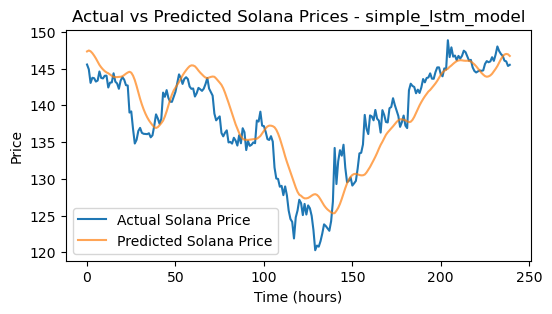

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6068e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step


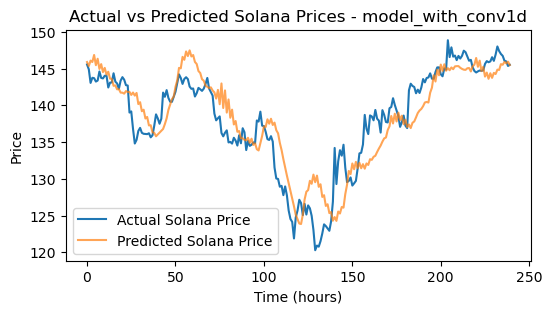

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0140
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step


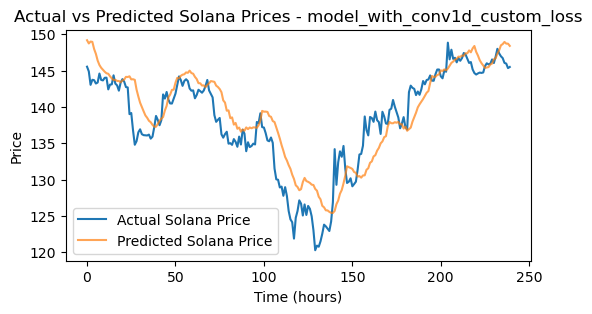

15:49:59 - cmdstanpy - INFO - Chain [1] start processing
15:50:20 - cmdstanpy - INFO - Chain [1] done processing


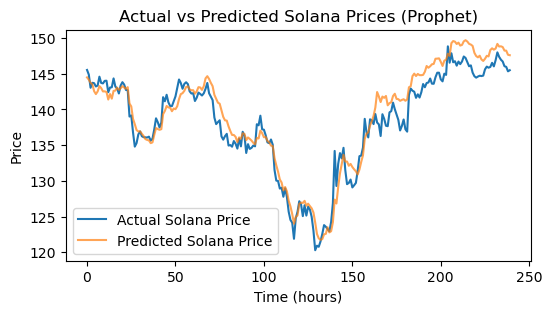

           LSTM  LSTM with Conv1D  LSTM with Conv1D & Custom Loss   Prophet
MSE   10.756233         10.805508                       10.955850  3.804908
RMSE   3.279670          3.287173                        3.309962  1.950617
MAE    2.537532          2.577121                        2.601777  1.617080


In [59]:
# Run the pipeline for each model
file_path = "https://raw.githubusercontent.com/ajkamali/Solana-/main/df_solana.csv"

metrics_simple_lstm = run_pipeline(file_path, simple_lstm_model,'simple_lstm_model')
metrics_conv1d = run_pipeline(file_path, model_with_conv1d,'model_with_conv1d')
metrics_custom_loss = run_pipeline(file_path, model_with_custom_loss,'model_with_conv1d_custom_loss')
metrics_prophet = run_pipeline(file_path, use_prophet=True)

# Aggregate and display metrics for comparison
metrics_comparison = {
    'LSTM': metrics_simple_lstm,
    'LSTM with Conv1D': metrics_conv1d,
    'LSTM with Conv1D & Custom Loss': metrics_custom_loss,
    'Prophet': metrics_prophet
    
}

print(pd.DataFrame(metrics_comparison))



# Model Deployment

## Deployment Strategy
The deployment strategy for the Solana cryptocurrency price forecasting model involves generating a comprehensive PDF report that includes all aspects of the model development and evaluation. This report will be provided to stakeholders to help them make informed business decisions based on the model's insights.

## Report Generation
This notebook will be converted into a PDF report which includes detailed documentation of the entire process from data collection to model evaluation. The PDF report will contain:

- Data collection and preparation steps
- Feature engineering details
- Model definition and training processes
- Model evaluation metrics and visualizations
- Architectural Decisions Document (ADD)
- Conclusion and recommendations

To generate the PDF report, follow these steps:
1. Ensure all cells in this notebook have been run and produce the correct output.
2. Use the `File` menu in the notebook interface.
3. Select `Download as` and then choose `PDF via LaTeX (.pdf)`.

This PDF report will be handed over to business stakeholders to provide them with a clear understanding of the model's development, performance, and potential applications.



# Architectural Decisions Document (ADD)

## Model Choices
**1. LSTM (Long Short-Term Memory):**
   - **Rationale**: LSTM networks are specifically designed to handle sequential and time-series data by maintaining a memory of previous inputs, which helps capture temporal dependencies. Given the nature of cryptocurrency prices, which are influenced by past values, LSTM is well-suited for this task.
   - **Advantages**: 
     - Can capture long-term dependencies due to its memory cells.
     - Suitable for handling time-series data with patterns and trends.
     - Robust to issues of vanishing gradients, making it effective for training deep networks.
   - **Limitations**: 
     - Computationally intensive, especially for long sequences.
     - Requires a significant amount of data for training effectively.

**2. ConvLSTM (Convolutional LSTM):**
   - **Rationale**: By combining convolutional layers with LSTM, ConvLSTM can capture both spatial and temporal features. This is particularly useful for capturing local patterns (like short-term trends) along with long-term dependencies.
   - **Advantages**: 
     - Efficiently captures local dependencies through convolutional layers.
     - Enhanced ability to model complex patterns in the data.
     - Better performance in terms of extracting features compared to plain LSTM.
   - **Limitations**: 
     - More complex to implement and train compared to plain LSTM.
     - Higher computational cost due to the combination of convolutional and LSTM layers.

**3. Custom Loss Function ConvLSTM (Custom Convolutional LSTM):**
   - **Rationale**: The Custom ConvLSTM model with a custom loss function combines the strengths of convolutional layers and LSTM layers while using a loss function that balances both mean squared error (MSE) and mean absolute error (MAE). This approach aims to capture complex spatial and temporal patterns and provide a more robust performance metric.
   - **Advantages**: 
     - Combining MSE and MAE helps in minimizing both large and small errors, leading to a more balanced model performance.
   - **Limitations**: 
     - More complex to implement and train compared to plain LSTM.
     - Higher computational cost due to the combination of convolutional and LSTM layers.
       
*
4**3. Prophet:**
   - **Rationale**: Prophet is an open-source forecasting tool developed by Facebook, designed for forecasting time-series data that exhibits daily seasonality, weekly seasonality, and yearly seasonality. It’s particularly effective for business time series data which often have strong seasonal effects.
   - **Advantages**: 
     - Easy to use with automatic handling of missing data and outliers.
     - Capable of capturing seasonality and holidays effects.
     - Provides interpretable parameters that can be used to understand the data better.
   - **Limitations**: 
     - Less flexible compared to neural network models for capturing complex non-linear patterns.
     - May not perform as well as deep learning models on highly non-linear and non-seasonal time-series data.

## Feature Selection
**1. Rolling Averages and Lag Features:**
   - **Rationale**: Rolling averages smooth out short-term fluctuations and highlight longer-term trends, while lag features provide past values of a time series, allowing models to learn temporal dependencies.
   - **Features Included**: 
     - Rolling averages (24-hour window) for price, market cap, and volume.
     - Lag features (24-hour lag) for price, market cap, and volume.
   - **Justification**: These features are essential for capturing both short-term and long-term trends and patterns in the cryptocurrency market, which are critical for accurate forecasting.

**2. Time-Based Features:**
   - **Rationale**: Time-based features help capture seasonality and cyclical patterns in the data, such as daily or weekly cycles.
   - **Features Included**: 
     - Hour of the day, day of the week, day of the month, month, year.
   - **Justification**: Cryptocurrencies can exhibit patterns based on time, such as increased activity during certain hours or days, which can be critical for accurate forecasting.

**3. Technical Indicators:**
   - **Rationale**: Technical indicators are widely used in financial markets to predict future price movements based on historical data.
   - **Features Included**: 
     - Simple Moving Average (SMA), Relative Strength Index (RSI), Moving Average Convergence Divergence (MACD).
   - **Justification**: These indicators provide insights into the momentum and trend strength, which are valuable for making informed predictions about future price movement
## Model Performance Assessment

   - **Mean Squared Error**: MSE metric measures the average squared difference between the actual and predicted values. It penalizes larger errors more heavily, providing a clear indication of model accuracy. Lower MSE values indicate better model performance.
   - **Root Mean Squared Error**: RMSE is the square root of MSE, which brings the error metric to the same scale as the target values. It is useful for interpreting the magnitude of prediction errors in a more understandable way. Lower RMSE values signify better model performance.
   - **Mean Absolute Error**: MAE metric measures the average absolute difference between actual and predicted values. Unlike MSE, MAE treats all errors equally, providing a straightforward interpretation of model accuracy. Lower MAE values indicate better model performance.eproducibility.


## Scalability and Maintenance
**1. Scalability:**
   - **Data Volume**: As the volume of data increases, the solution must scale to handle large datasets efficiently. This involves optimizing data processing pipelines and ensuring that the models can handle and learn from more data without significant performance degradation.
   - **Model Training**: For LSTM and ConvLSTM models, leveraging GPUs or TPUs can significantly reduce training time. Utilizing cloud services like AWS, GCP, or Azure can provide the necessary infrastructure to scale the training process.
   - **Prediction Serving**: Deploying the models using scalable services such as Kubernetes or cloud-based platforms (e.g., AWS SageMaker, Google AI Platform) ensures that the model can handle multiple requests and large-scale predictions concurrently.

**2. Maintenance:**
   - **Model Monitoring**: Continuously monitor the model’s performance to detect any drift or degradation in accuracy. Implementing automated monitoring tools and setting up alerts can help identify when a model retraining is needed.
   - **Retraining and Updates**: Establish a periodic retraining schedule to update the model with new data, ensuring that it remains accurate and relevant. Automating this process using tools like Airflow or MLflow can streamline the maintenance.
   - **Version Control**: Use version control for both the data and the model. Tools like DVC (Data Version Control) and Git can help keep track of changes and maintain a history of model versions and the data used for training.
   - **Documentation and Transparency**: Maintain comprehensive documentation of the model architecture, feature engineering process. This transparency aids in troubleshooting, understanding the model’s decision-making process, and ensuring reproducibility.


# Conclusion

## Summary of Findings
The project successfully demonstrated the use of various time series models, including LSTM, ConvLSTM, Custom ConvLSTM with a custom loss function, and Prophet, to forecast Solana cryptocurrency prices. While the ConvLSTM models, showed good performance in capturing complex patterns, the Prophet model provided superior results in this case. This highlights the importance of evaluating multiple approaches and selecting the best model based on empirical performance. The Prophet model's ability to capture seasonality and trends contributed to its superior performance.

## Recommendations
Based on the performance evaluation, it is recommended to deploy the Prophet model for real-time forecasting of Solana prices. However, the ConvLSTM model can serve as a valuable complementary tool, particularly for capturing non-linear and complex patterns. Continuous monitoring and periodic retraining of both models are necessary to maintain accuracy.

## Future Work
Future work could involve exploring more advanced neural network architectures, such as Transformers, which have shown promising results in time series forecasting. Additionally, integrating external data sources, such as social media sentiment or macroeconomic indicators, could further enhance the model's predictive power.
